В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [275]:
!pip install pyarrow --quiet
!pip install opendatasets --upgrade --quiet
!pip install catboost
!pip install xgboost lightgbm
!pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client
!pip install gdown

In [276]:
import opendatasets as od
import joblib

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import GenericUnivariateSelect, f_classif

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score

from scipy.stats import chi2_contingency

In [277]:
# URL of the Kaggle competition dataset
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'

# Downloading and extracting the dataset using opendatasets
od.download(dataset_url)


Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


In [278]:
data_dir = './bank-customer-churn-prediction-dlu'
os.listdir(data_dir)

['train.csv', 'sample_submission.csv', 'test.csv']

In [279]:
train_csv = data_dir + '/train.csv'

# Load the test data into a pandas DataFrame
data_train = pd.read_csv(train_csv)
data_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [280]:
# Check for null values
print(data_train.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [281]:
# Data types of columns
print("\nColumn Data Types:")
print(data_train.dtypes)


Column Data Types:
id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object


In [282]:
# Describe the dataframe
print(data_train.describe())

                 id    CustomerId   CreditScore           Age        Tenure  \
count  15000.000000  1.500000e+04  15000.000000  15000.000000  15000.000000   
mean    7499.500000  1.569146e+07    658.944133     37.739600      5.025267   
std     4330.271354  1.352050e+05     72.255926      8.218363      2.776678   
min        0.000000  1.581102e+06    431.000000     18.000000      0.000000   
25%     3749.750000  1.563514e+07    603.000000     32.000000      3.000000   
50%     7499.500000  1.569018e+07    662.000000     37.000000      5.000000   
75%    11249.250000  1.575718e+07    708.000000     42.000000      7.000000   
max    14999.000000  1.581569e+07    850.000000     74.000000     10.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   15000.000000   15000.000000  15000.000000    15000.000000   
mean    42729.791988       1.590933      0.788800        0.489667   
std     59727.309419       0.532306      0.408174        0.499910   
min         

In [283]:
# Identify unique values
unique_counts = data_train.nunique()
print(unique_counts)

id                 15000
CustomerId          6348
Surname              764
CreditScore          378
Geography              3
Gender                 2
Age                   56
Tenure                11
Balance             3395
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     6242
Exited                 2
dtype: int64


In [284]:
# Check for overdetermined or underdetermined system based on number of rows and features
num_rows = data_train.shape[0]
num_features = data_train.shape[1] - 1 # Exited is the target variable
if num_rows > num_features:
    print("The system is overdetermined.")
elif num_rows < num_features:
    print("The system is underdetermined.")
else:
    print("The system is determined.")

The system is overdetermined.


In [285]:
# Briefly check test dataset

test_csv = data_dir + '/test.csv'

# Load the test data into a pandas DataFrame
data_test = pd.read_csv(test_csv)
data_test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [286]:
# Check for null values
print(data_test.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [287]:
# Data types of columns
print("\nColumn Data Types:")
print(data_test.dtypes)


Column Data Types:
id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object


In [288]:
# Describe the dataframe
print(data_test.describe())

                id    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean   19999.50000  1.569344e+07    658.091500     37.882600      5.042000   
std     2886.89568  7.155043e+04     72.168634      8.166143      2.797681   
min    15000.00000  1.556588e+07    431.000000     18.000000      0.000000   
25%    17499.75000  1.563539e+07    602.000000     32.000000      3.000000   
50%    19999.50000  1.569083e+07    661.000000     37.000000      5.000000   
75%    22499.25000  1.575941e+07    708.000000     42.000000      7.000000   
max    24999.00000  1.581566e+07    850.000000     74.000000     11.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.000000    10000.000000   
mean    42828.366454       1.585600      0.780300        0.481900   
std     59904.661559       0.530943      0.414064        0.499697   
min         0.000000 

In [289]:
# Identify unique values
unique_counts = data_test.nunique()
print(unique_counts)

id                 10000
CustomerId          5141
Surname              699
CreditScore          365
Geography              3
Gender                 2
Age                   56
Tenure                12
Balance             2514
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     4980
dtype: int64


In [290]:
# Check for overdetermined or underdetermined system based on number of rows and features
num_rows = data_test.shape[0]
num_features = data_test.shape[1] - 1 # Exited is the target variable
if num_rows > num_features:
    print("The system is overdetermined.")
elif num_rows < num_features:
    print("The system is underdetermined.")
else:
    print("The system is determined.")

The system is overdetermined.


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [291]:
from sklearn.model_selection import train_test_split
target_col = 'Exited'

# Define input columns
input_cols = data_train.columns.drop(target_col)

# Split data into features (inputs) and target variable (target)
X = data_train[input_cols]
y = data_train[target_col]

# Split data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create subsets
train_inputs = X_train
train_targets = y_train
val_inputs = X_val
val_targets = y_val

# Print obtained subsets
print(f'Size of train_inputs: {train_inputs.shape}')
print(f'Size of train_targets: {train_targets.shape}')
print(f'Size of val_inputs: {val_inputs.shape}')
print(f'Size of val_targets: {val_targets.shape}')

Size of train_inputs: (12000, 13)
Size of train_targets: (12000,)
Size of val_inputs: (3000, 13)
Size of val_targets: (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [292]:
# Define numerical columns
numeric_cols = data_train.select_dtypes(include=['number']).columns.tolist()

# Define categorical columns
categorical_cols = data_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Print results
print("Numerical columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Categorical columns: ['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [293]:
# Encode Geography
data_train_encoded = pd.get_dummies(data_train, columns=['Geography'], prefix='Geography', dtype=int)

# Encode Gender
data_train_encoded['Gender'] = data_train_encoded['Gender'].map({'Male': 0, 'Female': 1})

print(data_train_encoded.head())


   id  CustomerId   Surname  CreditScore  Gender   Age  Tenure    Balance  \
0   0  15779985.0   Nwankwo        678.0       0  29.0     4.0       0.00   
1   1  15650086.0     Ch'in        687.0       1  34.0     1.0       0.00   
2   2  15733602.0  Thompson        682.0       1  52.0     6.0       0.00   
3   3  15645794.0   Macleod        753.0       0  44.0     6.0   83347.25   
4   4  15633840.0      Hsia        544.0       1  55.0     0.0  107747.57   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0            3.0        1.0             0.0        180626.36     0.0   
1            2.0        0.0             1.0         63736.17     0.0   
2            3.0        0.0             0.0        179655.87     1.0   
3            2.0        1.0             0.0        161407.48     0.0   
4            1.0        1.0             0.0        176580.86     1.0   

   Geography_France  Geography_Germany  Geography_Spain  
0                 1                  0        

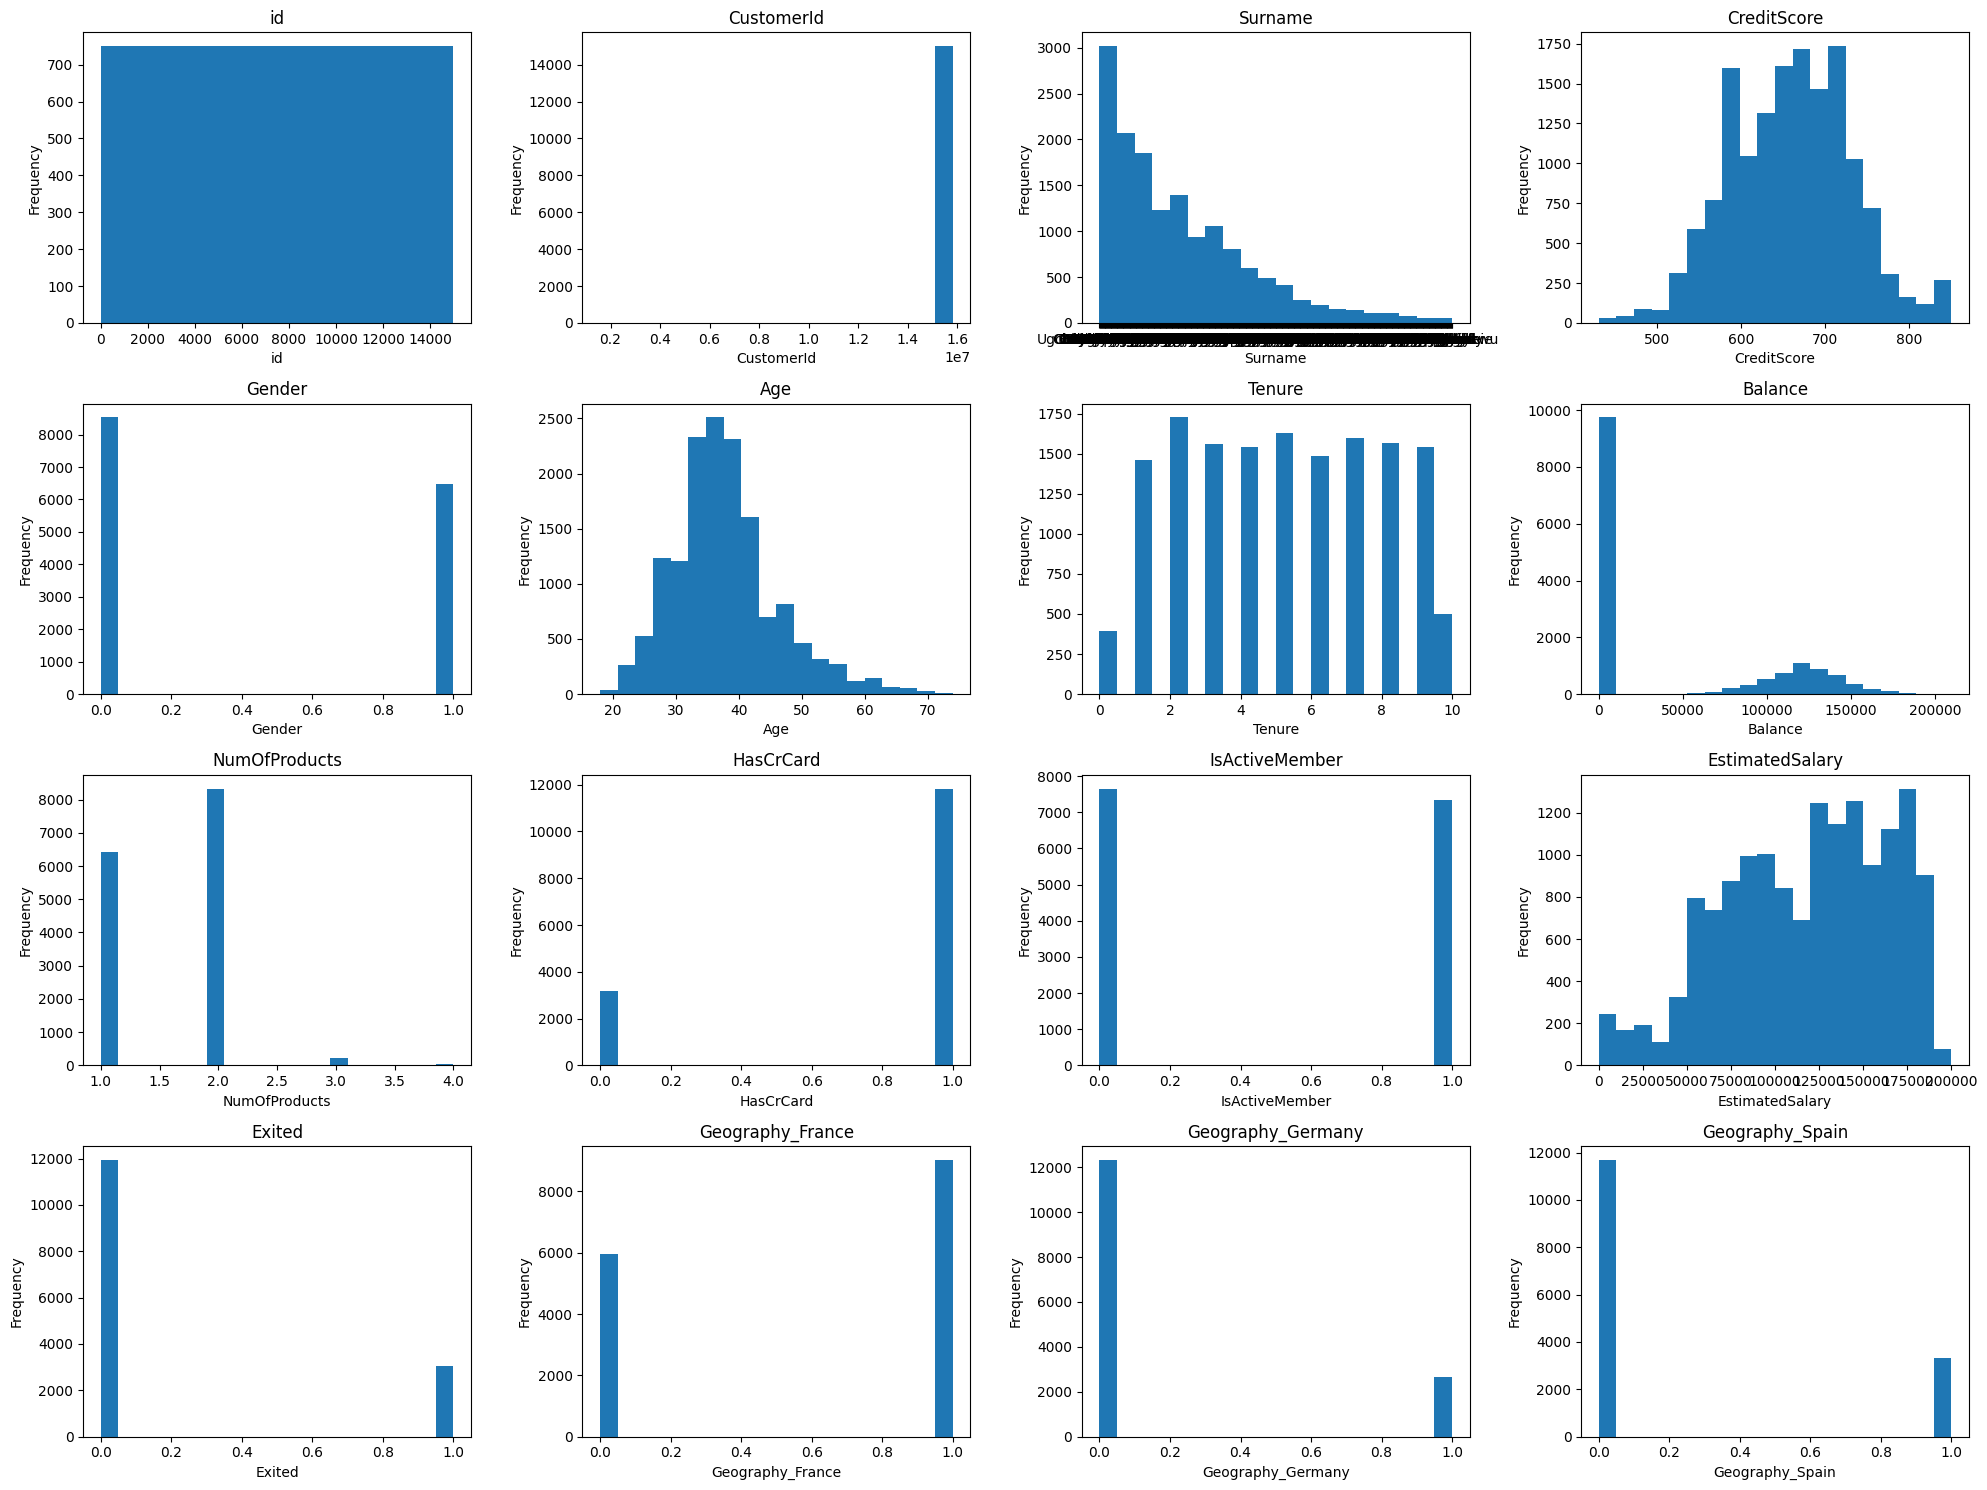

In [294]:
plt.figure(figsize=(20, 15))

for i, column in enumerate(data_train_encoded.columns):
  plt.subplot(4, 4, i + 1)
  plt.hist(data_train_encoded[column], bins=20)
  plt.title(column)
  plt.xlabel(column)
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

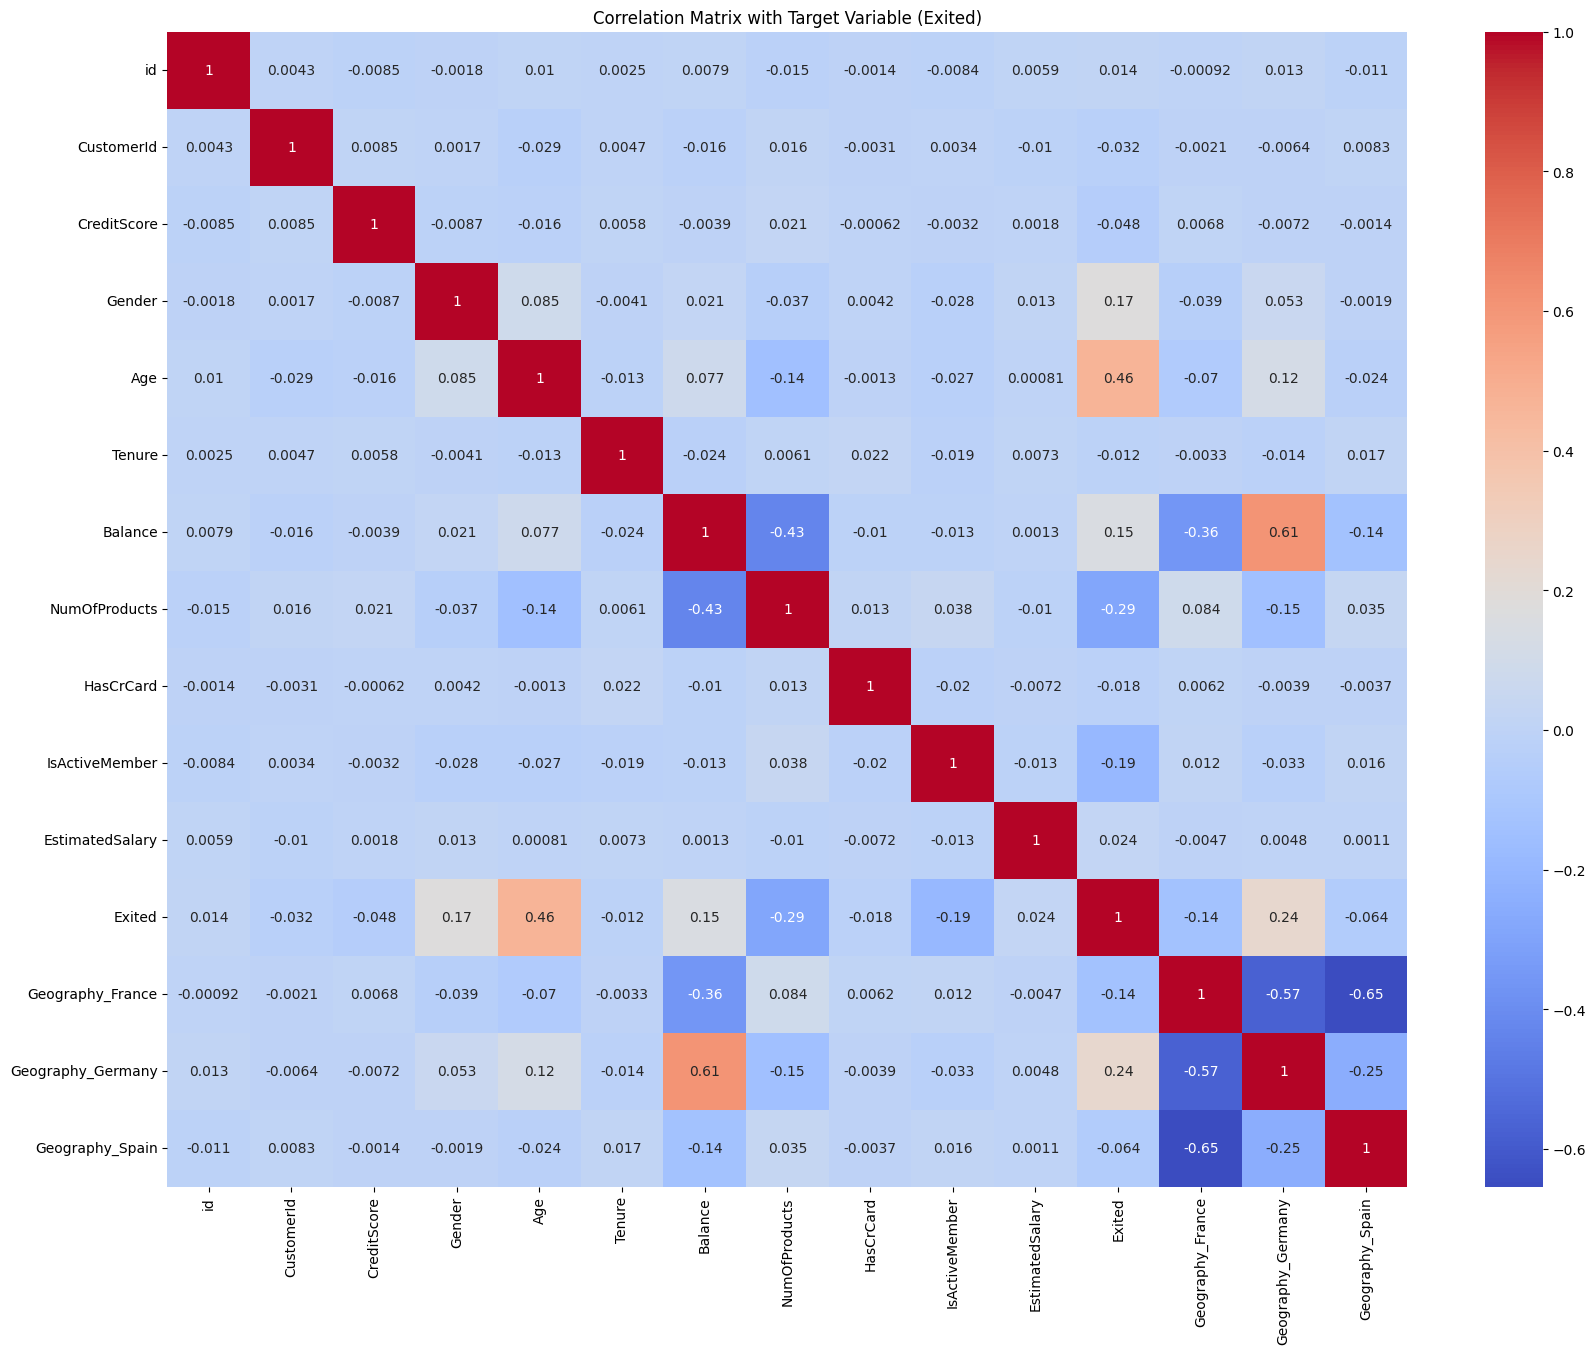

In [295]:
# Correlation heatmap with Pearson coefficient (chi_contigency no longer needed as all categorical variables are encoded)
plt.figure(figsize=(20, 15))
plt.title('Correlation Matrix with Target Variable (Exited)')
numerical_data = data_train_encoded.select_dtypes(include=np.number)

sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.show()


In [296]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features and target
X = data_train_encoded.drop(columns=[target_col, 'Surname'])  # Remove target and 'Surname' column from feature set
y = data_train_encoded[target_col]

# Split train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Only include numeric transformer in the preprocessor since there are no categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns)])

# Preprocessed data
train_inputs = preprocessor.fit_transform(X_train)
val_inputs = preprocessor.transform(X_val)

# Display first 5 values
pd.set_option('display.max_columns', None)

train_inputs_df = pd.DataFrame(train_inputs, columns=X_train.columns)
val_inputs_df = pd.DataFrame(val_inputs, columns=X_val.columns)

print("Train Inputs:")
display(train_inputs_df.head())

print("\nValidation Inputs:")
display(val_inputs_df.head())


Train Inputs:


,id,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.069136,-0.263441,0.320187,-0.863250,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,0.814938,-0.467331,-0.530827
1,0.672227,-0.666919,0.347838,1.158413,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,0.814938,-0.467331,-0.530827
2,-1.707380,0.569420,0.638166,-0.863250,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,-1.227087,2.139813,-0.530827
3,-0.949404,0.610162,0.140460,-0.863250,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,-1.227087,-0.467331,1.883853
4,1.097479,-0.332313,0.665816,-0.863250,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,0.814938,-0.467331,-0.530827



Validation Inputs:


,id,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.228346,0.703904,0.762592,-0.863250,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,-1.227087,2.139813,-0.530827
1,-0.884566,-0.500773,-0.910252,-0.863250,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,0.814938,-0.467331,-0.530827
2,-0.501540,0.660086,0.997620,1.158413,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,0.814938,-0.467331,-0.530827
3,-1.575398,0.765385,0.195761,1.158413,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,0.814938,-0.467331,-0.530827
4,-1.119689,0.554699,0.264887,1.158413,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,-1.227087,-0.467331,1.883853


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [297]:
from scipy.sparse import csr_matrix

# Data preprocessing pipeline for numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                          ('scaler', StandardScaler())]), X_train.columns)])

# Transform data
train_inputs = preprocessor.fit_transform(X_train)
val_inputs = preprocessor.transform(X_val)

# Convert to dense if sparse
train_inputs = train_inputs.toarray() if isinstance(train_inputs, csr_matrix) else train_inputs
val_inputs = val_inputs.toarray() if isinstance(val_inputs, csr_matrix) else val_inputs

# Define output directory
output_dir = "/content/drive/MyDrive/Colab Notebooks/processed_data"
os.makedirs(output_dir, exist_ok=True)

# Save data to Parquet format
for name, data in zip(['train_inputs', 'train_targets', 'val_inputs', 'val_targets'],
                      [train_inputs, y_train.values.reshape(-1, 1), val_inputs, y_val.values.reshape(-1, 1)]):
    pd.DataFrame(data, columns=X_train.columns if 'inputs' in name else [target_col]).to_parquet(
        os.path.join(output_dir, f'{name}.parquet'), index=False)

# List files in directory
print("List of files in directory:", os.listdir(output_dir))


List of files in directory: ['train_inputs.parquet', 'val_targets.parquet', 'train_targets.parquet', 'val_inputs.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [298]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_inputs, train_targets.ravel())

# Predict on the Logistic Regression model
train_predictions = model.predict_proba(train_inputs)[:, 1]
val_predictions = model.predict_proba(val_inputs)[:, 1]

# Evaluate ROC AUC
roc_auc_train = roc_auc_score(train_targets, train_predictions)
roc_auc_val = roc_auc_score(val_targets, val_predictions)

print(f'ROC AUC train: {roc_auc_train:.4f}')
print(f'ROC AUC val: {roc_auc_val:.4f}')

ROC AUC train: 0.8830
ROC AUC val: 0.8799


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      9558
         1.0       0.77      0.55      0.64      2442

    accuracy                           0.87     12000
   macro avg       0.83      0.75      0.78     12000
weighted avg       0.87      0.87      0.87     12000

Confusion Matrix:
[[9155  403]
 [1100 1342]]
Accuracy: 0.8748
F1 Score: 0.6410


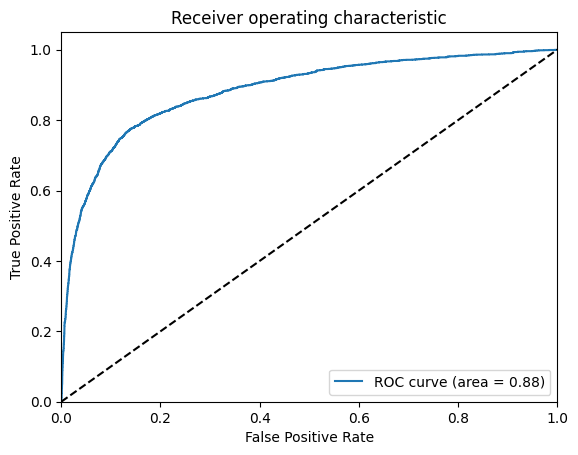

AUROC: 0.8830
The model appears to be good, with a high AUROC score.


In [299]:
# Predict class labels for training data using the trained model
train_predictions_labels = (train_predictions > 0.5).astype(int)

# Generate the classification report
print(classification_report(train_targets, train_predictions_labels))

# Generate and print the confusion matrix
cm = confusion_matrix(train_targets, train_predictions_labels)
print("Confusion Matrix:")
print(cm)

# Calculate the accuracy score
accuracy = accuracy_score(train_targets, train_predictions_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the F1 score
f1 = f1_score(train_targets, train_predictions_labels)
print(f"F1 Score: {f1:.4f}")

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(train_targets, train_predictions)
roc_auc = roc_auc_score(train_targets, train_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUROC: {roc_auc:.4f}")

# Interpretation of model quality
if roc_auc > 0.8:
    print("The model appears to be good, with a high AUROC score.")
elif roc_auc > 0.7:
    print("The model is decent, with a reasonable AUROC score.")
else:
    print("The model's performance is not very good, consider improving it.")


              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2390
         1.0       0.73      0.57      0.64       610

    accuracy                           0.87      3000
   macro avg       0.81      0.76      0.78      3000
weighted avg       0.86      0.87      0.86      3000

Confusion Matrix:
[[2261  129]
 [ 262  348]]
Accuracy: 0.8697
F1 Score: 0.6403


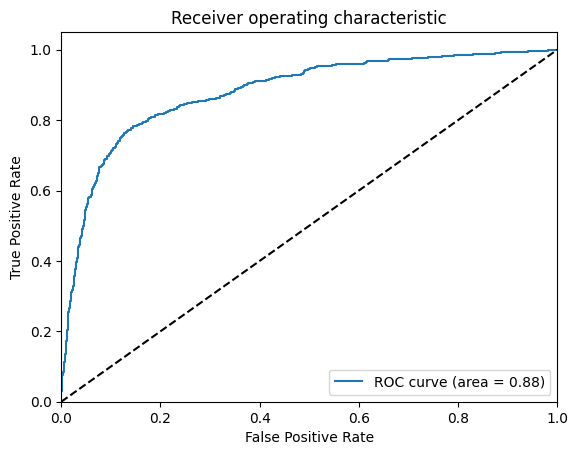

AUROC: 0.8799
The model appears to be good, with a high AUROC score.


In [300]:
# Predict class labels for validation data using the trained model
val_predictions_labels = (val_predictions > 0.5).astype(int)

# Generate the classification report
print(classification_report(val_targets, val_predictions_labels))

# Generate and print the confusion matrix
cm = confusion_matrix(val_targets, val_predictions_labels)
print("Confusion Matrix:")
print(cm)

# Calculate the accuracy score
accuracy = accuracy_score(val_targets, val_predictions_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the F1 score
f1 = f1_score(val_targets, val_predictions_labels)
print(f"F1 Score: {f1:.4f}")

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)
roc_auc = roc_auc_score(val_targets, val_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUROC: {roc_auc:.4f}")

# Interpretation of model quality
if roc_auc > 0.8:
    print("The model appears to be good, with a high AUROC score.")
elif roc_auc > 0.7:
    print("The model is decent, with a reasonable AUROC score.")
else:
    print("The model's performance is not very good, consider improving it.")

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [301]:
# Find the majority class in the training data
majority_class = train_targets.mode()[0]

# Create predictions for the majority class model
train_predictions_majority = np.full(train_targets.shape, majority_class)
val_predictions_majority = np.full(val_targets.shape, majority_class)

# Calculate accuracy for the majority class model
train_accuracy_majority = accuracy_score(train_targets, train_predictions_majority)
val_accuracy_majority = accuracy_score(val_targets, val_predictions_majority)

# Calculate accuracy for the trained Logistic Regression model
train_accuracy_logistic = accuracy_score(train_targets, train_predictions_labels)
val_accuracy_logistic = accuracy_score(val_targets, val_predictions_labels)

print("Accuracy of Majority Class Model:")
print(f"Train Accuracy: {train_accuracy_majority:.4f}")
print(f"Validation Accuracy: {val_accuracy_majority:.4f}")

print("\nAccuracy of Logistic Regression Model:")
print(f"Train Accuracy: {train_accuracy_logistic:.4f}")
print(f"Validation Accuracy: {val_accuracy_logistic:.4f}")

# Conclusion about the quality of our model
if val_accuracy_logistic > val_accuracy_majority:
  print("\nThe quality of our Logistic Regression model is better than the majority class model, indicating it has learned something meaningful from the data.")
  if val_accuracy_logistic > 0.8:
    print("The model's quality is good.")
  elif val_accuracy_logistic > 0.7:
    print("The model's quality is decent.")
  else:
    print("The model's quality is not very good, consider further improvements.")
else:
  print("\nThe quality of our Logistic Regression model is not better than the majority class model, indicating it may not have learned effectively from the data. We may need to further refine the model or consider different approaches.")

Accuracy of Majority Class Model:
Train Accuracy: 0.7965
Validation Accuracy: 0.7967

Accuracy of Logistic Regression Model:
Train Accuracy: 0.8748
Validation Accuracy: 0.8697

The quality of our Logistic Regression model is better than the majority class model, indicating it has learned something meaningful from the data.
The model's quality is good.


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

# Initialize and train the model with scaled inputs
scaler = StandardScaler(with_mean=False)
model = LogisticRegression()

train_inputs_scaled = scaler.fit_transform(train_inputs)
model.fit(train_inputs_scaled, train_targets)

# Save model, scaler, and input columns
joblib.dump({'model': model, 'scaler': scaler, 'input_columns': input_cols}, 'log_reg.joblib')

# Load saved model and scaler
loaded_objects = joblib.load('log_reg.joblib')
model, scaler, input_cols = loaded_objects['model'], loaded_objects['scaler'], loaded_objects['input_columns']


In [303]:
print("Trained Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)
print("Scaler Mean (if applicable):", scaler.mean_ if scaler.with_mean else "Mean not used")
print("Scaler Scale:", scaler.scale_)
print("Input Columns:", input_cols)


Trained Model Coefficients: [[ 0.00686141 -0.17861028 -0.15397155  0.43157121  1.29156365 -0.01858993
  -0.33079146 -0.72148853 -0.07634342 -0.64057404  0.04854059 -0.19198095
   0.46452311 -0.20321512]]
Model Intercept: [-2.1046707]
Scaler Mean (if applicable): Mean not used
Scaler Scale: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Input Columns: Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [304]:
loaded_objects = joblib.load('log_reg.joblib')
model, scaler, input_cols = loaded_objects['model'], loaded_objects['scaler'], loaded_objects['input_columns']

print("Loaded Model Coefficients:", model.coef_)
print("Loaded Input Columns:", input_cols)


Loaded Model Coefficients: [[ 0.00686141 -0.17861028 -0.15397155  0.43157121  1.29156365 -0.01858993
  -0.33079146 -0.72148853 -0.07634342 -0.64057404  0.04854059 -0.19198095
   0.46452311 -0.20321512]]
Loaded Input Columns: Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [305]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoder_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoder_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [306]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Assuming model is already trained and scaler is already fitted

def predict_raw_df(scaler, input_df: pd.DataFrame, model):
    # Define numeric columns (numerical data types)
    numeric_cols = input_df.select_dtypes(include=['number'])

    # Define categorical columns (object or category types)
    categorical_cols = input_df.select_dtypes(include=['object', 'category'])

    # Step 1: Handle categorical encoding (Geography and Gender)
    # Geography: One-hot encode
    input_df = pd.get_dummies(input_df, columns=['Geography'], prefix='Geography', dtype=int)

    # Gender: Map 'Male' to 0 and 'Female' to 1
    if 'Gender' in categorical_cols:
        input_df['Gender'] = input_df['Gender'].map({'Male': 0, 'Female': 1})

    # Step 2: Scale numeric columns
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    # Step 3: Prepare final input for prediction (numeric + encoded categorical columns)
    # Get encoded categorical columns (those created by pd.get_dummies for Geography)
    encoder_cols = [col for col in input_df.columns if col.startswith('Geography')]  # Extract Geography columns
    X_input = input_df[numeric_cols + encoder_cols]  # Combine numeric and encoded categorical columns

    # Step 4: Predict the probabilities for class 1
    prob = model.predict_proba(X_input)[:, 1]  # Class 1 probability
    return prob


11. Зчитайте дані з test.csv в змінну test_raw_df. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку Exited в датафреймі test_raw_df.

In [307]:
# Load the input data from test.csv
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')

In [309]:
# Make predictions
predictions = predict_raw_df(model, loaded_objects, test_raw_df)

# Add the predictions to the DataFrame
test_raw_df['Exited'] = predictions

AttributeError: 'dict' object has no attribute 'select_dtypes'

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the sample submission file
submission_df =  pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')

# Ensure the 'Exited' column is filled with predictions
submission_df['Exited'] = predictions

# Save the updated DataFrame to a new CSV file
submission_df.to_csv('drive/MyDrive/Colab Notebooks/data//submission_log_reg.csv', index=False)

In [ ]:
# Display the first 5 rows of the final dataset
print(submission_df.head())